In [2]:
# Load in relevant modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader

from src.data import FraudDataset, prepare_train_valid_test
from src.models import MLPClassifier
from src.train import train

# Turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [3]:
# Load in the data
df = pd.read_csv('data/creditcard.csv')

In [4]:
# The first step is to create train, validation, and test datasets.
df_train, df_valid, df_test = prepare_train_valid_test(df, valid_prop=.15, test_prop=.15)

In [5]:
# Next I need to calculate the class weights to pass into the loss function
# to account for class imbalance. 
class_counts_dict = dict(df_train.groupby('Class').agg('count')['Time'])
class_weights = [1 - class_counts_dict[class_idx]/sum(class_counts_dict.values()) \
                 for class_idx in [0, 1]]

In [6]:
# Create data objects that can efficiently be passed into PyTorch
training_data = DataLoader(FraudDataset(df_train), batch_size=1024, shuffle=False)
validation_data = DataLoader(FraudDataset(df_valid), batch_size=1024, shuffle=False)
test_data = DataLoader(FraudDataset(df_test), batch_size=1024, shuffle=False)

loss at epoch 0: 0.002417297102510929
loss at epoch 100: 0.0017771789571270347
loss at epoch 200: 0.0015642320504412055
loss at epoch 300: 0.0014183936873450875
loss at epoch 400: 0.0013108071871101856
loss at epoch 500: 0.0012390079209581017
loss at epoch 600: 0.0011739194160327315
loss at epoch 700: 0.001142291584983468
loss at epoch 800: 0.0010929843410849571
loss at epoch 900: 0.0010709144407883286


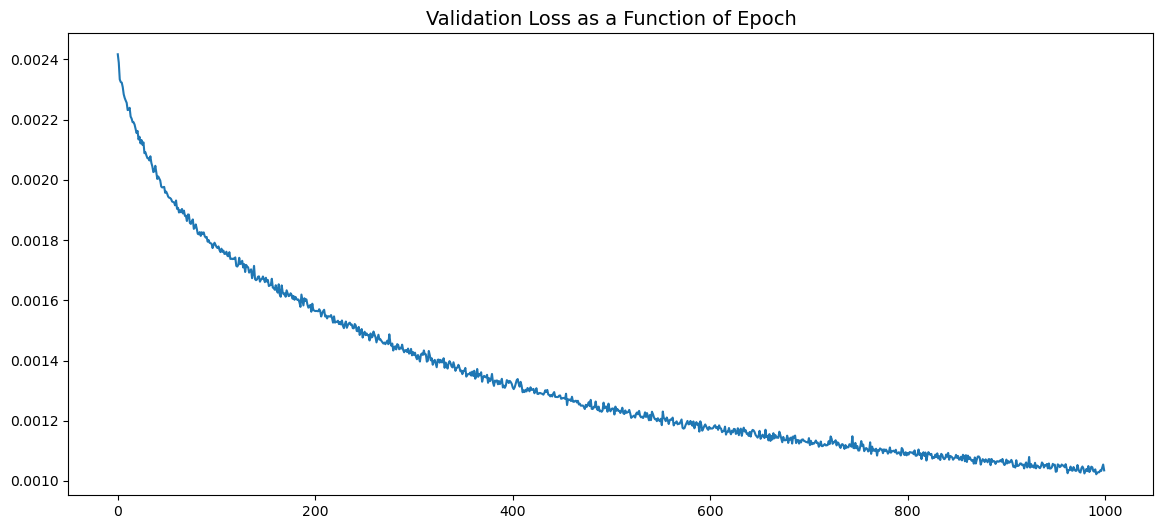

In [7]:
# Define model
mlp_model = MLPClassifier(n_input=30, layers=[30, 30, 30, 2], dropout=.5)

# Train model
train(training_data, validation_data, mlp_model, 'mlp',
      n_epochs=1000, lr=.001, loss_weights=class_weights)

In [11]:
# See how model performs on some random positive examples
real_labels = list(df_test['Class'])
counter = 0
while counter < 10:
    idx = random.randint(0, len(df_test)-1)
    if real_labels[idx] == 1:
        pred = mlp_model(torch.tensor(df_test.iloc[:, :-1].values)[idx].unsqueeze(dim=0).float())
        print(f"predicted: {torch.argmax(pred[0])}, actual: {real_labels[idx]}")
        counter += 1

predicted: 1, actual: 1
predicted: 1, actual: 1
predicted: 1, actual: 1
predicted: 1, actual: 1
predicted: 0, actual: 1
predicted: 1, actual: 1
predicted: 1, actual: 1
predicted: 1, actual: 1
predicted: 0, actual: 1
predicted: 1, actual: 1


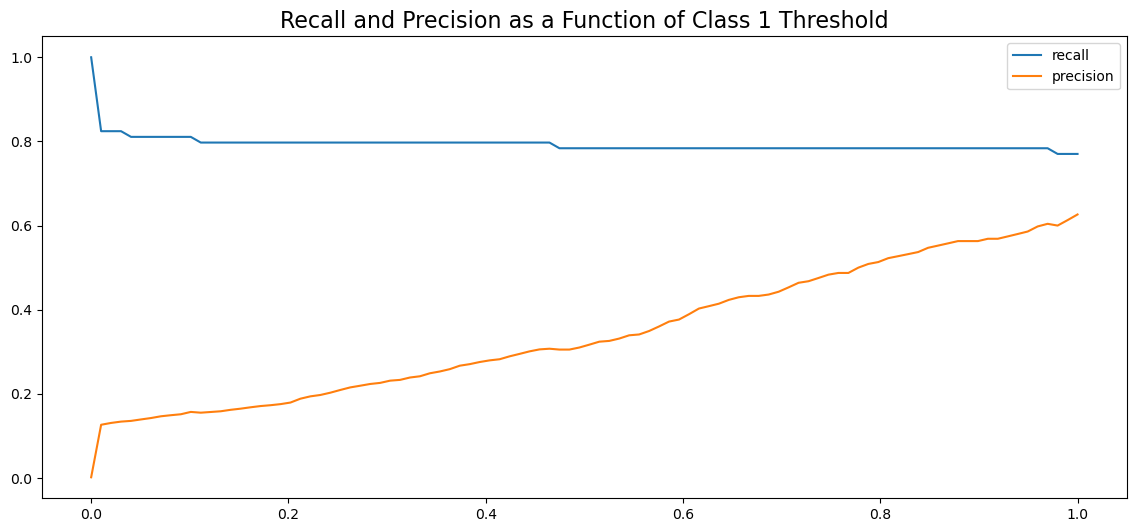

In [12]:
# Tune threshold on validation set
preds = mlp_model(torch.tensor(df_valid.iloc[:, :-1].values).float())
fraud_indices = np.array(list(df_valid.reset_index()[df_valid.reset_index()['Class'] == 1].index))
not_fraud_indices = np.array(list(df_valid.reset_index()[df_valid.reset_index()['Class'] == 0].index))

# Standardize each prediction so that the rows sum to 1
class_preds = (preds / torch.sum(preds, dim=1).reshape(-1, 1))

# Get list of class 1 probabilities
class_1_probs = class_preds[:, 1].detach().numpy()

# Preds on positive labels
pos_preds = class_1_probs[fraud_indices]

# Preds on negative labels
neg_preds = class_1_probs[not_fraud_indices]

# Plot precision as a function of threshold
precision_list = []

# Plot recall as a function of thresold
recall_list = []

for threshold in np.linspace(0, 1, 100):
    tp = len(pos_preds[pos_preds >= threshold])
    fn = len(pos_preds) - tp
    tn = len(neg_preds[neg_preds < threshold])
    fp = len(neg_preds) - tn
    recall_list.append(tp / (tp+fn))
    precision_list.append(tp / (tp+fp))
    
plt.figure(figsize=(14,6))
plt.title('Recall and Precision as a Function of Class 1 Threshold', fontsize=16)
plt.plot(np.linspace(0, 1, 100), recall_list, label='recall')
plt.plot(np.linspace(0, 1, 100), precision_list, label='precision')
plt.legend()
plt.show()

**Takeaway**: The optimal threshold seems to be around .85 as this yields high recall without sacrificing too much precision.

In [19]:
# Assess overall success on the test set
preds = mlp_model(torch.tensor(df_test.iloc[:, :-1].values).float())
fraud_indices = np.array(list(df_test.reset_index()[df_test.reset_index()['Class'] == 1].index))
not_fraud_indices = np.array(list(df_test.reset_index()[df_test.reset_index()['Class'] == 0].index))

# Standardize each prediction so that the rows sum to 1
class_preds = (preds / torch.sum(preds, dim=1).reshape(-1, 1))

# Get list of class 1 probabilities
class_1_probs = class_preds[:, 1].detach().numpy()

# Preds on positive labels
pos_preds = class_1_probs[fraud_indices]

# Preds on negative labels
neg_preds = class_1_probs[not_fraud_indices]

tp = len(pos_preds[pos_preds >= 1])
fn = len(pos_preds) - tp
tn = len(neg_preds[neg_preds < 1])
fp = len(neg_preds) - tn
recall = tp / (tp+fn)
precision = tp / (tp+fp)
accuracy = (tp+tn) / (tp+tn+fp+fn)

print(f'accuracy: {np.round(100*accuracy, 2)}%')
print(f'precision: {np.round(100*precision, 2)}%')
print(f'recall: {np.round(100*recall, 2)}%')

accuracy: 99.93%
precision: 69.81%
recall: 71.15%
